In [1]:
import os.path
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform
from matplotlib import gridspec
from scipy import stats

# Set plot style and size
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Color Clustering Analysis
# 1. Load and explore the data
def load_data(file_path='Final_clustering/K=3/CBS_Percentages.csv'):
    """Load the color profile data"""
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    return df

df = load_data()

# # Display the first few rows
# print("\nFirst 5 rows:")
# display(df.head())

# # Basic statistics
# print("\nBasic statistics:")
# display(df.describe())

Dataset shape: (2587, 4)


In [3]:
# 3. Prepare data for clustering
def prepare_data_for_clustering(df):
    """Prepare the data for clustering by separating features and scaling"""
    # Extract features (color percentages) and image names
    X = df.drop('VideoID', axis=1).values
    image_names = df['VideoID'].values
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, image_names, scaler

X_scaled, image_names, scaler = prepare_data_for_clustering(df)

In [4]:
# 5. Perform clustering with optimal k
def perform_clustering(X, k):
    """Perform KMeans clustering"""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    return kmeans, labels

kmeans, labels = perform_clustering(X_scaled, 3)    #change optimal_k to another k to see different results

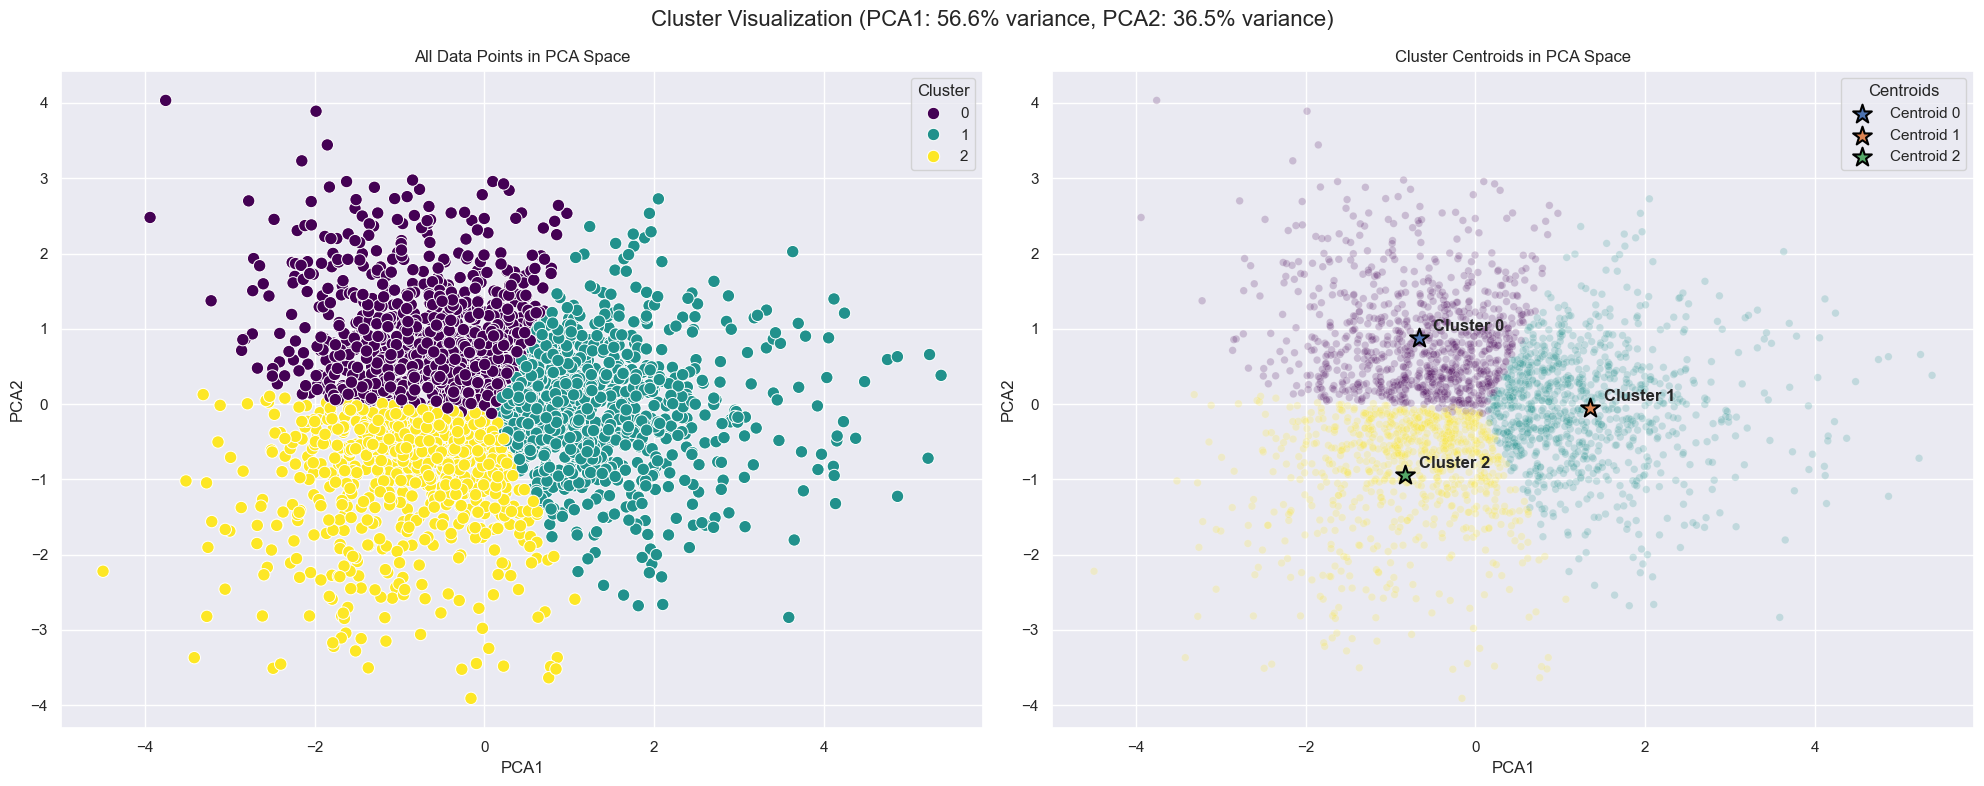

In [5]:
def visualize_clusters_pca_with_centroids(X, labels, image_names):
    """Visualize clusters in 2D using PCA with a side-by-side plot showing centroids"""
    # Apply PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create DataFrame for easier plotting
    pca_df = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 
                          'Cluster': labels, 'Image': image_names})
    
    # Calculate cluster centroids in original space
    n_clusters = len(np.unique(labels))
    centroids_orig = np.zeros((n_clusters, X.shape[1]))
    
    for i in range(n_clusters):
        centroids_orig[i] = np.mean(X[labels == i], axis=0)
    
    # Project centroids onto PCA space
    centroids_pca = pca.transform(centroids_orig)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: All data points
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=80, ax=ax1)
    ax1.set_title('All Data Points in PCA Space')
    ax1.legend(title='Cluster')
    
    # Right plot: Centroids only
    # First plot all points with reduced opacity for context
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', 
                   s=30, alpha=0.2, legend=False, ax=ax2)
    
    # Then plot centroids as larger points with labels
    for i in range(n_clusters):
        ax2.scatter(centroids_pca[i, 0], centroids_pca[i, 1], s=200, c=f'C{i}', 
                   marker='*', edgecolors='black', linewidth=1.5, label=f'Centroid {i}')
        ax2.annotate(f'Cluster {i}', (centroids_pca[i, 0], centroids_pca[i, 1]),
                   xytext=(10, 5), textcoords='offset points', fontsize=12, fontweight='bold')
    
    ax2.set_title('Cluster Centroids in PCA Space')
    ax2.legend(title='Centroids', loc='upper right')
    
    # Add information about variance explained
    explained_var = pca.explained_variance_ratio_
    fig.suptitle(f'Cluster Visualization (PCA1: {explained_var[0]:.1%} variance, PCA2: {explained_var[1]:.1%} variance)',
                fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    return pca, X_pca, centroids_pca

# Call the updated function
pca, X_pca, centroids_pca = visualize_clusters_pca_with_centroids(X_scaled, labels, image_names)

Add Cluster number of the thumbnails

In [6]:
# Read the existing CBS percentages
df = pd.read_csv('Final_clustering/K=3/CBS_Percentages.csv')

# Create feature matrix for clustering
X = df[['colorfulness', 'brightness', 'saturation']].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Save the updated dataframe with cluster assignments
df.to_csv('Final_clustering/K=3/CBS_Percentages.csv', index=False)

# Print cluster sizes
print("\nCluster sizes:")
print(df['Cluster'].value_counts().sort_index())


Cluster sizes:
Cluster
0    921
1    880
2    786
Name: count, dtype: int64


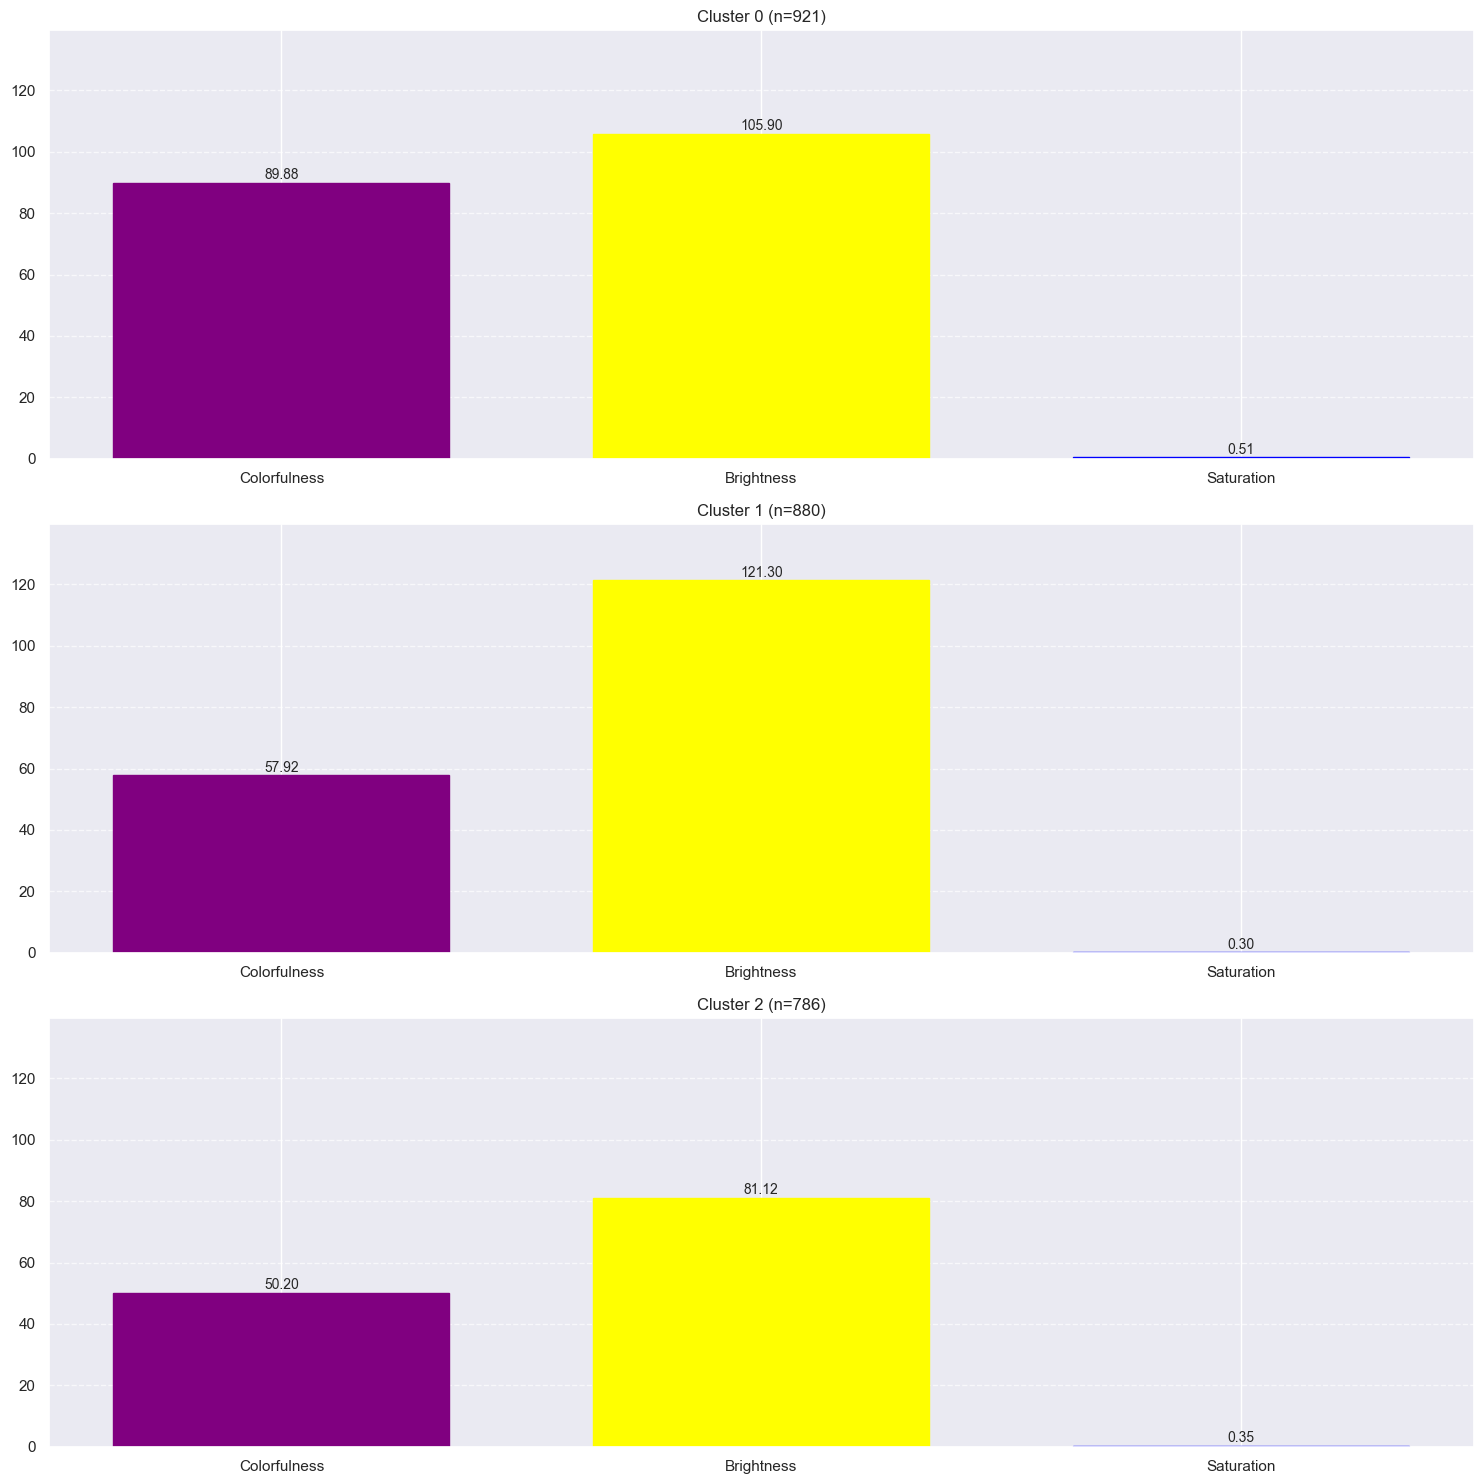


Cluster sizes:
Cluster
0    921
1    880
2    786
Name: count, dtype: int64


In [7]:
def analyze_cbs_clusters(df, labels, k):
    """Analyze the characteristics of each cluster based on CBS metrics"""
    # Add cluster labels to the original DataFrame
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels
    
    # Calculate mean CBS values for each cluster
    cbs_cols = ['colorfulness', 'brightness', 'saturation']
    cluster_means = df_clustered.groupby('Cluster')[cbs_cols].mean()
    
    # Create figure with subplots
    plt.figure(figsize=(15, 5 * k))
    
    for i in range(k):
        plt.subplot(k, 1, i+1)
        
        cluster_profile = cluster_means.iloc[i]
        
        # Create bar plot
        width = 0.7
        bar_positions = np.arange(len(cluster_profile.index))
        bars = plt.bar(bar_positions, cluster_profile.values, width=width)
        
        # Color each bar based on metric
        colors = ['purple', 'yellow', 'blue']  # Colors for colorfulness, brightness, saturation
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.1,
                f'{height:.2f}',
                ha='center', 
                va='bottom', 
                rotation=0,
                fontsize=10
            )
        
        plt.title(f'Cluster {i} (n={sum(labels == i)})', fontsize=12)
        plt.ylim(0, max(cluster_means.values.max() * 1.15, 1))
        plt.xticks(bar_positions, ['Colorfulness', 'Brightness', 'Saturation'], rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return df_clustered, cluster_means

# Read your CBS data
df = pd.read_csv('Final_clustering/K=3/CBS_Percentages.csv')        #change file name

# Create feature matrix and scale
X = df[['colorfulness', 'brightness', 'saturation']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Analyze clusters
df_clustered, cluster_means = analyze_cbs_clusters(df, labels, 3)


Cluster 0 examples (showing 10 out of 921):
  - aPgwD05HHKE.jpg: {'Colorfulness': '129.81', 'Brightness': '95.14', 'Saturation': '0.77'}
  - ufL2Oj1EtxA.jpg: {'Colorfulness': '65.08', 'Brightness': '102.30', 'Saturation': '0.47'}
  - 71BQ4YNhVxA.jpg: {'Colorfulness': '106.12', 'Brightness': '103.79', 'Saturation': '0.44'}
  - R965if9bSGg.jpg: {'Colorfulness': '83.90', 'Brightness': '115.74', 'Saturation': '0.45'}
  - asVHaM9QXzQ.jpg: {'Colorfulness': '111.66', 'Brightness': '94.23', 'Saturation': '0.54'}
  - _qoxcsCD7kw.jpg: {'Colorfulness': '82.06', 'Brightness': '113.13', 'Saturation': '0.39'}
  - yBeRdhX1FMk.jpg: {'Colorfulness': '69.65', 'Brightness': '93.84', 'Saturation': '0.48'}
  - TSv5dcZ_NRQ.jpg: {'Colorfulness': '117.72', 'Brightness': '125.32', 'Saturation': '0.49'}
  - 35THbgakNBk.jpg: {'Colorfulness': '77.19', 'Brightness': '88.10', 'Saturation': '0.44'}
  - c185R3zpFQk.jpg: {'Colorfulness': '102.70', 'Brightness': '112.23', 'Saturation': '0.55'}


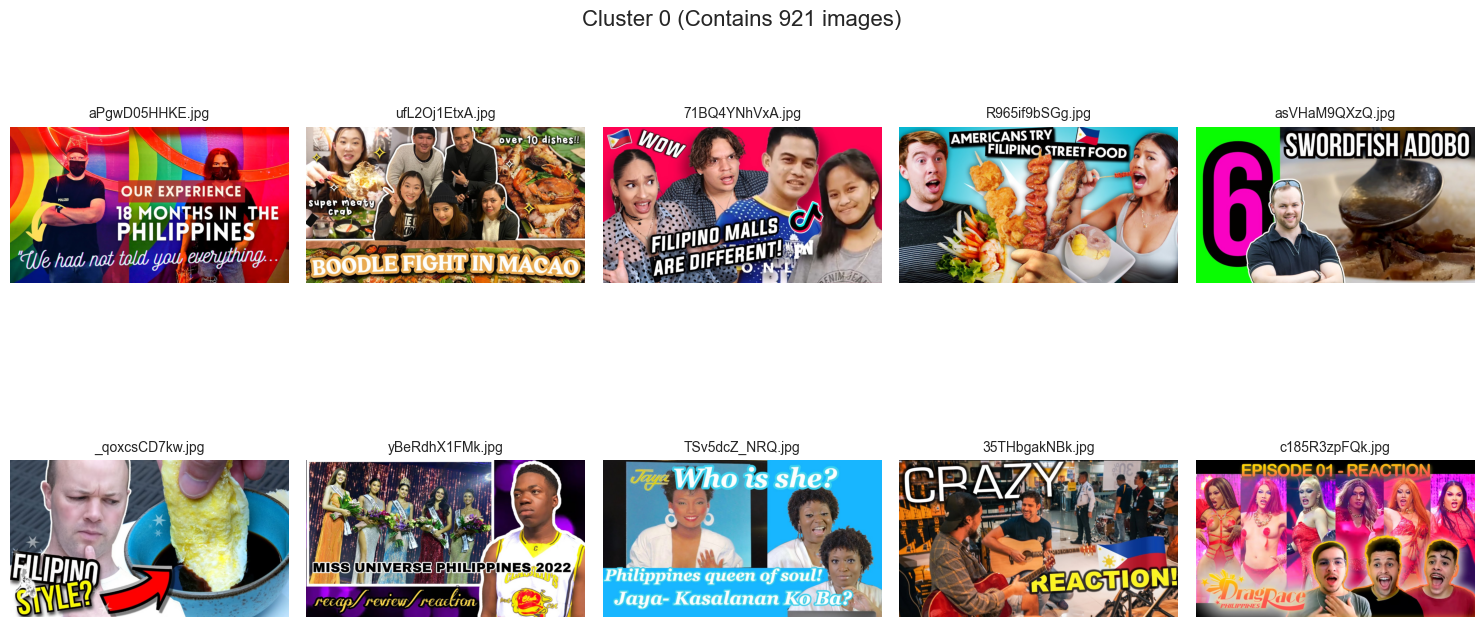


Cluster 1 examples (showing 10 out of 880):
  - K0FmdB8uGKA.jpg: {'Colorfulness': '21.24', 'Brightness': '101.07', 'Saturation': '0.18'}
  - fi-1XRsB_CM.jpg: {'Colorfulness': '62.19', 'Brightness': '104.01', 'Saturation': '0.33'}
  - kTrjYBGGol0.jpg: {'Colorfulness': '50.04', 'Brightness': '104.80', 'Saturation': '0.29'}
  - 7zNSjbWBo90.jpg: {'Colorfulness': '70.79', 'Brightness': '137.39', 'Saturation': '0.41'}
  - HhzVar8JGss.jpg: {'Colorfulness': '69.16', 'Brightness': '108.90', 'Saturation': '0.38'}
  - 3xy9jS1KwvY.jpg: {'Colorfulness': '65.05', 'Brightness': '111.05', 'Saturation': '0.37'}
  - ql1RNZzrs2E.jpg: {'Colorfulness': '45.87', 'Brightness': '130.94', 'Saturation': '0.26'}
  - 2g63ty8ySoM.jpg: {'Colorfulness': '35.88', 'Brightness': '187.87', 'Saturation': '0.13'}
  - 0mDJwB6DLvg.jpg: {'Colorfulness': '23.54', 'Brightness': '114.20', 'Saturation': '0.21'}
  - hUogazKVhDQ.jpg: {'Colorfulness': '61.98', 'Brightness': '110.73', 'Saturation': '0.25'}


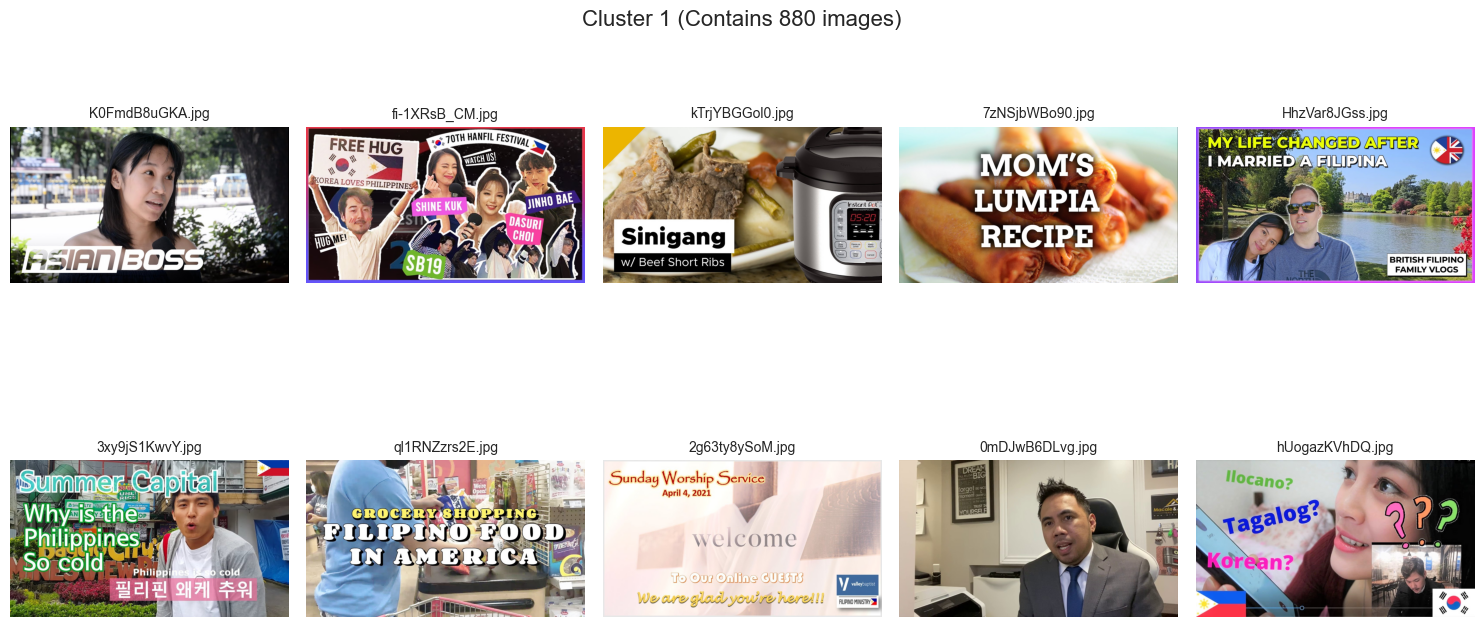


Cluster 2 examples (showing 10 out of 786):
  - CEfyMNrHkMs.jpg: {'Colorfulness': '59.04', 'Brightness': '92.00', 'Saturation': '0.38'}
  - qzdU92L30NA.jpg: {'Colorfulness': '85.13', 'Brightness': '63.29', 'Saturation': '0.33'}
  - WHhcj9jYdL8.jpg: {'Colorfulness': '41.67', 'Brightness': '61.80', 'Saturation': '0.39'}
  - WS8eYFLtwSY.jpg: {'Colorfulness': '50.00', 'Brightness': '99.18', 'Saturation': '0.40'}
  - hqSAIh6wLSg.jpg: {'Colorfulness': '64.87', 'Brightness': '100.02', 'Saturation': '0.37'}
  - P-I4Bay5SXo.jpg: {'Colorfulness': '46.94', 'Brightness': '62.30', 'Saturation': '0.30'}
  - Jf2tNIE-IHE.jpg: {'Colorfulness': '68.23', 'Brightness': '71.08', 'Saturation': '0.46'}
  - CIzI1u5i8B8.jpg: {'Colorfulness': '41.44', 'Brightness': '92.97', 'Saturation': '0.37'}
  - AI7Us_5-IaQ.jpg: {'Colorfulness': '48.92', 'Brightness': '78.07', 'Saturation': '0.44'}
  - T9zN_s3m5xM.jpg: {'Colorfulness': '47.83', 'Brightness': '101.13', 'Saturation': '0.30'}


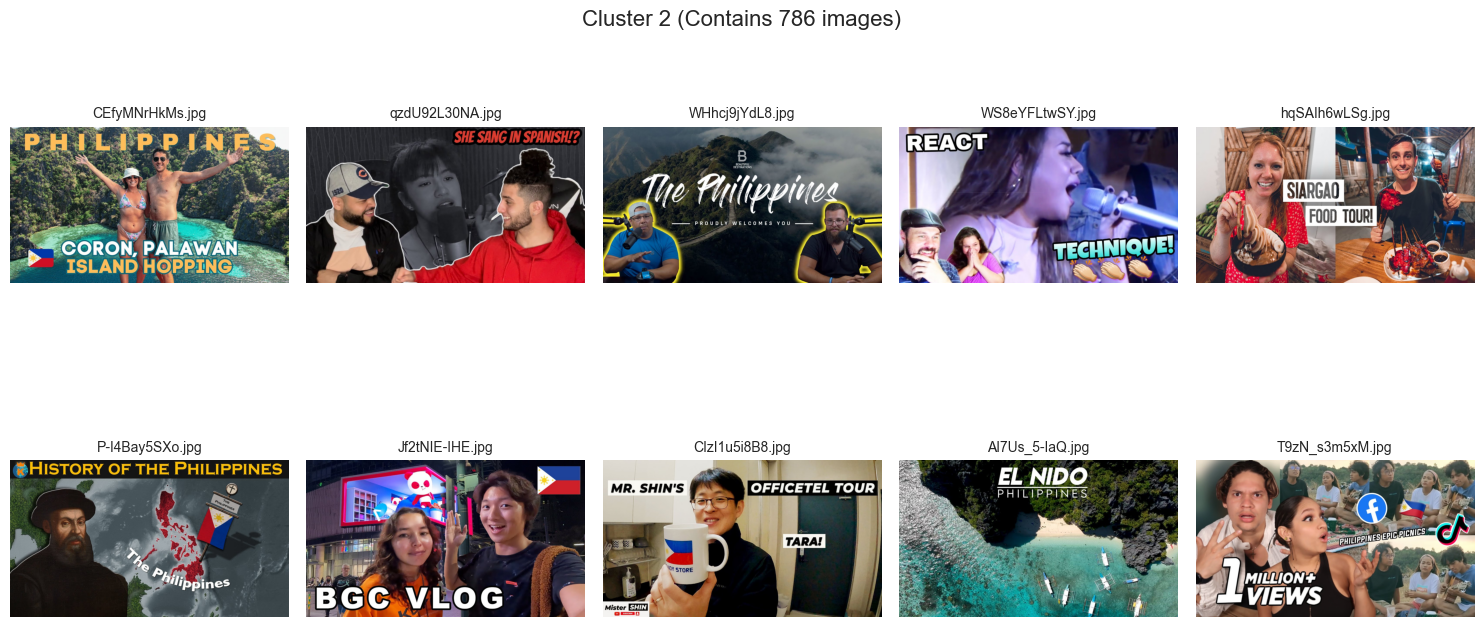

In [8]:
def display_cbs_cluster_examples(df_clustered, image_dir="Final_clustering/thumbnails-filtered", num_examples=10):
    """
    Display example images from each cluster with their CBS metrics
    
    Parameters:
    -----------
    df_clustered : pandas DataFrame
        DataFrame containing image data with Cluster column and CBS metrics
    image_dir : str
        Directory path where the images are stored
    num_examples : int
        Number of example images to show per cluster
    """
    for cluster_id in sorted(df_clustered['Cluster'].unique()):
        cluster_samples = df_clustered[df_clustered['Cluster'] == cluster_id]
        samples = cluster_samples.sample(min(num_examples, len(cluster_samples)))
        
        print(f"Cluster {cluster_id} examples (showing {len(samples)} out of {len(cluster_samples)}):")
        
        # Limit to 5 images per row
        images_per_row = 5
        n_samples = len(samples)
        n_rows = math.ceil(n_samples / images_per_row)
        
        # Create figure with image rows
        fig, axs = plt.subplots(n_rows, images_per_row, figsize=(15, 3.5 * n_rows))
        fig.suptitle(f'Cluster {cluster_id} (Contains {len(cluster_samples)} images)', fontsize=16)
        
        # Handle single row case
        if n_rows == 1:
            axs = np.array([axs])
        
        # Process each sample
        for i, (_, row) in enumerate(samples.iterrows()):
            row_idx = i // images_per_row
            col_idx = i % images_per_row
            img_ax = axs[row_idx, col_idx]
            
            image_path = os.path.join(image_dir, row['VideoID'])
            
            try:
                img = Image.open(image_path)
                img_ax.imshow(img)
                img_ax.set_title(row['VideoID'], fontsize=10)
                img_ax.axis('off')
                
                # Extract CBS metrics
                cbs_metrics = {
                    'Colorfulness': f"{row['colorfulness']:.2f}",
                    'Brightness': f"{row['brightness']:.2f}",
                    'Saturation': f"{row['saturation']:.2f}"
                }
                
                # Print CBS metrics
                print(f"  - {row['VideoID']}: ", end="")
                print(cbs_metrics)
                
            except Exception as e:
                img_ax.text(0.5, 0.5, f"Image not found\n{row['VideoID']}", 
                          horizontalalignment='center', verticalalignment='center')
                img_ax.axis('off')
                print(f"  - Error loading {row['VideoID']}: {e}")
        
        # Hide any unused subplots
        for i in range(n_samples, n_rows * images_per_row):
            row_idx = i // images_per_row
            col_idx = i % images_per_row
            axs[row_idx, col_idx].axis('off')
            
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, hspace=0.2)
        plt.show()
        print()


# To use these functions:
display_cbs_cluster_examples(df_clustered, image_dir="Final_clustering/thumbnails-filtered")

Put the thumbnails in a grid pic (50 pics per picture)

In [9]:
def create_cluster_grids():
    # Read the clustered data
    df = pd.read_csv("Final_clustering/K=3/CBS_Percentages.csv")    #change the file name 
    
    # Create output directory
    output_dir = "Final_clustering/K=3/Cluster thumbnails"                      #change the file name   
    os.makedirs(output_dir, exist_ok=True)
    
    # Get unique clusters
    clusters = sorted(df['Cluster'].unique())
    
    # Set parameters
    thumb_size = 200
    margin = 10  # Margin between thumbnails
    max_images_per_grid = 50
    
    for cluster_id in clusters:
        # Get all images in this cluster
        cluster_images = df[df['Cluster'] == cluster_id]
        
        # Split into chunks of max_images_per_grid
        total_images = len(cluster_images)
        num_grids = math.ceil(total_images / max_images_per_grid)
        
        for grid_num in range(num_grids):
            # Get subset of images for this grid
            start_idx = grid_num * max_images_per_grid
            end_idx = min((grid_num + 1) * max_images_per_grid, total_images)
            current_batch = cluster_images.iloc[start_idx:end_idx]
            
            # Calculate grid dimensions (5 columns, n rows)
            n_images = len(current_batch)
            n_cols = 5
            n_rows = math.ceil(n_images / n_cols)
            
            # Create a new image for the grid with margins
            grid_width = (n_cols * thumb_size) + ((n_cols + 1) * margin)
            grid_height = (n_rows * thumb_size) + ((n_rows + 1) * margin)
            grid_image = Image.new('RGB', (grid_width, grid_height), 'white')
            
            # Place each thumbnail in the grid
            for idx, (_, row) in enumerate(current_batch.iterrows()):
                # Calculate position in grid with margins
                row_idx = idx // n_cols
                col_idx = idx % n_cols
                
                x_pos = margin + (col_idx * (thumb_size + margin))
                y_pos = margin + (row_idx * (thumb_size + margin))
                
                # Load and resize thumbnail
                thumb_path = os.path.join("Final_Clustering/thumbnails-filtered", row['VideoID'])
                try:
                    thumb = Image.open(thumb_path)
                    thumb = thumb.resize((thumb_size, thumb_size))
                    
                    # Paste thumbnail into grid
                    grid_image.paste(thumb, (x_pos, y_pos))
                except Exception as e:
                    print(f"Error processing {row['VideoID']}: {e}")
            
            # Save the grid image with appropriate numbering
            if num_grids == 1:
                output_path = os.path.join(output_dir, f"cluster_{cluster_id}.png")
            else:
                output_path = os.path.join(output_dir, f"cluster_{cluster_id}.{grid_num + 1}.png")
            
            grid_image.save(output_path)
            print(f"Created {output_path} with {n_images} images")

create_cluster_grids()

Created Final_clustering/K=3/Cluster thumbnails\cluster_0.1.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.2.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.3.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.4.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.5.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.6.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.7.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.8.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.9.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.10.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.11.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\cluster_0.12.png with 50 images
Created Final_clustering/K=3/Cluster thumbnails\c

Put all thumbnail per cluster in one pic

In [10]:
# Put the thumbnails in a grid pic
def create_cluster_grids_one():
    # Read the clustered data
    df = pd.read_csv("Final_Clustering/K=3/CBS_Percentages.csv")    #change the file name
    
    # Create output directory
    output_dir = "Final_clustering/K=3/Cluster thumbnails (one pic per cluster)"        #change the file name
    os.makedirs(output_dir, exist_ok=True)
    
    # Get unique clusters
    clusters = sorted(df['Cluster'].unique())
    
    for cluster_id in clusters:
        # Get all images in this cluster
        cluster_images = df[df['Cluster'] == cluster_id]
        
        # Calculate grid dimensions (5 columns, n rows)
        n_images = len(cluster_images)
        n_cols = 5
        n_rows = math.ceil(n_images / n_cols)
        
        # Create a new image for the grid
        # Assuming each thumbnail is 200x200 pixels
        thumb_size = 200
        grid_width = n_cols * thumb_size
        grid_height = n_rows * thumb_size
        grid_image = Image.new('RGB', (grid_width, grid_height), 'white')
        
        # Place each thumbnail in the grid
        for idx, (_, row) in enumerate(cluster_images.iterrows()):
            # Calculate position in grid
            row_idx = idx // n_cols
            col_idx = idx % n_cols
            
            # Load and resize thumbnail
            thumb_path = os.path.join("Final_Clustering/thumbnails-filtered", row['VideoID'])
            try:
                thumb = Image.open(thumb_path)
                thumb = thumb.resize((thumb_size, thumb_size))
                
                # Paste thumbnail into grid
                grid_image.paste(thumb, (col_idx * thumb_size, row_idx * thumb_size))
            except Exception as e:
                print(f"Error processing {row['VideoID']}: {e}")
        
        # Save the grid image
        output_path = os.path.join(output_dir, f"cluster_{cluster_id}.png")
        grid_image.save(output_path)
        print(f"Created {output_path} with {n_images} images")

create_cluster_grids_one()


Created Final_clustering/K=3/Cluster thumbnails (one pic per cluster)\cluster_0.png with 921 images
Created Final_clustering/K=3/Cluster thumbnails (one pic per cluster)\cluster_1.png with 880 images
Created Final_clustering/K=3/Cluster thumbnails (one pic per cluster)\cluster_2.png with 786 images
